# Surface Air Temperature Trends in the CESM1 Large Ensemble

This notebook will load in surface air temperature output from the CESM1 Large Ensemble historical and RCP8.5 simulations (1920-2100); it only loads data over the continental United States to keep the file size small enough to host online. 

First step, run the first two cells, which simply load the needed Python packages and specify the netcdf file to work with.

In [54]:
#load packages
import xarray as xr
import numpy as np
import random
import warnings
import os
import matplotlib.pyplot as plt

In [55]:
#specify data location and construct filename associated with a single ensemble member
lensdir = os.getcwd() + '/cesm1_lens_tas_CONUS/'
member = random.randint(1, 40)

files = sorted(os.listdir(lensdir))
files = [s for s in files if "rcp85" in s]
file = [s for s in files if "r" + str(member) + "i" in s]
filename = lensdir+file[0]
display(filename)

'/glade/u/home/rwills/cesm1_lens_tas_CONUS/tas_Amon_CESM1-CAM5_historical_rcp85_CONUS_r28i1p1_192001-210012.nc'

## Load data at latitude/longitude of interest and take seasonal average

The following cell loads the surface air temperature data at a single latitude/longitude (set to Corvallis, OR by default). The latitude/longitude used can be changed with *lon_plot* and *lat_plot*, but keep it at Corvallis for now. 

This cell also takes a seasonal average over June-July-August (JJA). The season can also be modified with the *season_select* variable ('DJF', 'MAM', 'SON').

In [56]:
## load surface air temperature data for a specified longitude and latitude
lon_plot = 360 - 123.26 # Corvallis (123.26°W)
lat_plot = 44.56 # Corvallis (44.56° N)
season_select = 'DJF'

# Miami: 25.7617° N, 80.1918° W
#lon_plot = 360-80.19
#lat_plot = 25.76

if lat_plot>49 or lat_plot<23 or lon_plot<235 or lon_plot>290:
    print('Error: lat/lon out of CONUS domain, reseting to default')
    lon_plot = 360 - 123.26 # Corvalis (123.26°W)
    lat_plot = 44.56 # Corvallis (44.56° N)
          
ds_tas = xr.open_dataset(filename)
lon = ds_tas.lon
lat = ds_tas.lat
year = ds_tas.time.dt.year
years = year[::12]
month = ds_tas.time.dt.month
time = year+month/12

tas = ds_tas.tas.sel(lon=lon_plot, lat=lat_plot, method="nearest")-273.15

## Seaonal average
# mask other months with nan
tas_seasonal = tas.where(tas['time.season'] == season_select)
if 'DJF' in season_select:
    tas_seasonal = tas_seasonal.rolling(min_periods=3, center=True, time=3).mean()
    warnings.simplefilter("ignore")
    tas_seasonal = tas_seasonal.groupby('time.year').mean('time')
    warnings.simplefilter("default")
else:
    tas_seasonal = tas_seasonal.groupby('time.year').mean('time')

## Compute linear trend and plot

The following cell computes the linear temperature trend for the chosen location over the period specified with *trend_year_1* and *trend_year_2*. It also plots the surface air temperature time series for the chosen location, together with the linear trend. **Please report back on PollEverywhere.com the reported value of JJA Surface Air Temperature Change per 50 years.**

'DJF Surface Air Temperature Change = 3.0°C per 50 years'

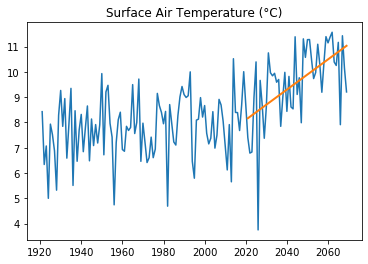

In [57]:
# Compute linear trend over next 50 years (2021-2070) and plot
trend_year_1 = 2021
trend_year_2 = 2070

i1920 = np.where(years.values==1920)
i1920 = int(i1920[0])
istart = np.where(years.values==trend_year_1)
istart = int(istart[0])
iend = np.where(years.values==trend_year_2)
iend = int(iend[0])
p = np.polyfit(years.values[istart:iend], tas_seasonal.values[istart:iend], 1)
x = years.values[istart:iend]

f=plt.figure()
plt.plot(years.values[i1920:iend],tas_seasonal.values[i1920:iend])
plt.plot(x,p[0]*x+p[1],linewidth=2)
plt.title('Surface Air Temperature (°C)')

display(season_select + " Surface Air Temperature Change = " + str(round(p[0]*50,1)) + "°C per 50 years")

## Stop Here

Don't go past here until we've discussed the above. If you have extra time, try changing *lon_plot*, *lat_plot*, or *season_select* and think about how the resulting plot changes qualitatively and quantitatively. 

## Part II: Ensemble Distribution and Ensemble Average

The following two cells repeat the above procedure for all 40 ensemble members. The first cell reports a histogram of the 50-year temperature trends for the chosen location and season. The second cell plots the time series for all ensemble members (in grey), as well as the ensemble average timeseries and the linear trend of the ensemble average timeseries.

Text(0.5, 1.0, 'Histogram: DJF Surface Air Temperature Change per 50 years')

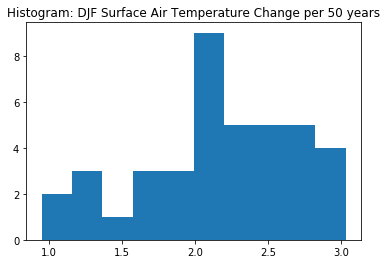

In [53]:
# Repeat the procedure for all ensemble members

dT = [0 for i in range(40)]
tas_seasonal_all = np.empty((len(tas_seasonal.values[i1920:iend]),40))

for i in range(40):
    file = [s for s in files if "r" + str(i+1) + "i" in s]
    filename = lensdir+file[0]
    
    ds_tas = xr.open_dataset(filename)
    tas = ds_tas.tas.sel(lon=lon_plot, lat=lat_plot, method="nearest")-273.15
    
    tas_seasonal = tas.where(tas['time.season'] == season_select)
    if 'DJF' in season_select:
        tas_seasonal = tas_seasonal.rolling(min_periods=3, center=True, time=3).mean()
        warnings.simplefilter("ignore")
        tas_seasonal = tas_seasonal.groupby('time.year').mean('time')
        warnings.simplefilter("default")
    else:
        tas_seasonal = tas_seasonal.groupby('time.year').mean('time')
    
    year = ds_tas.time.dt.year
    years = year[::12]
    i1920 = np.where(years.values==1920)
    i1920 = int(i1920[0])
    istart = np.where(years.values==trend_year_1)
    istart = int(istart[0])
    iend = np.where(years.values==trend_year_2)
    iend = int(iend[0])
    
    p = np.polyfit(years.values[istart:iend], tas_seasonal.values[istart:iend], 1)
    tas_seasonal_all[:,i] = tas_seasonal.values[i1920:iend]
    dT[i] = p[0]*50
    
f=plt.figure()
plt.hist(dT)
plt.title("Histogram: " + season_select + " Surface Air Temperature Change per 50 years")

'Ensemble Mean DJF Surface Air Temperature Change = 2.2°C per 50 years'

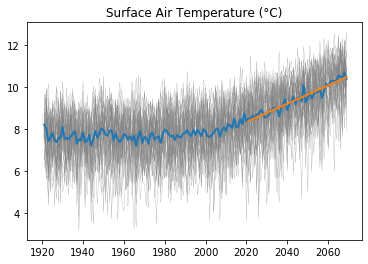

In [48]:
tas_seasonal_emean = np.mean(tas_seasonal_all,axis=1)

p = np.polyfit(years.values[istart:iend], tas_seasonal_emean[istart:iend], 1)
x = years.values[istart:iend]

f=plt.figure()
plt.plot(years.values[i1920:iend],tas_seasonal_all,color='grey',linewidth=0.2)
plt.plot(years.values[i1920:iend],np.mean(tas_seasonal_all,axis=1),linewidth=2)
plt.plot(x,p[0]*x+p[1],linewidth=2)
plt.title('Surface Air Temperature (°C)')

display("Ensemble Mean " + season_select + " Surface Air Temperature Change = " + str(round(p[0]*50,1)) + "°C per 50 years")